In [76]:
using JuMP
using MadNLP
using ProgressMeter
using CairoMakie

In [77]:
num_atoms = 10
num_bonds = num_atoms - 1
fps = 30
pref_dist = 1.
init_L = num_bonds*pref_dist
max_pull_perc = 0.3
max_crack = (1 + max_pull_perc)*init_L - (num_bonds-1)*pref_dist
break_dist = 2*pref_dist
pot_min = -1
diss_coeff = 1.
time_pull = 2.
l2_dissipation = true
soft_max_alpha = 10
time_horizon = time_pull
animation_width = 800
hidpi_scaling = 2
file_name = "line_crack"
fontsize = 16
only_video = true; # if false generate a folder of snapshots for each frame

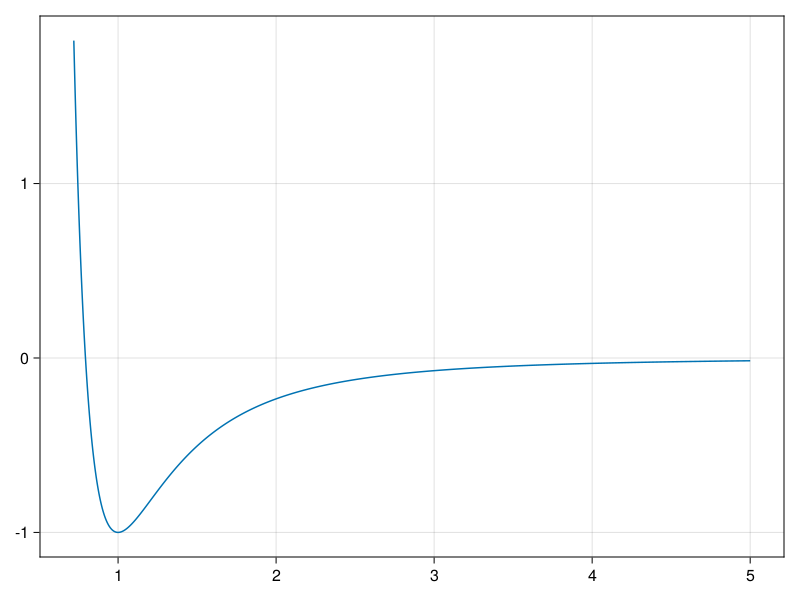

In [78]:
function lennard_jones(dist_sq; pot_min=-1)
    # Lennard-jones of squared distances.
    # The factor cbrt(2) assures that the global minimum 
    # is attained at cur_dist == pref_dist
    q = pref_dist^2/(cbrt(2)*dist_sq)
    -4*pot_min*(q^6 - q^3)
#     q = pref_dist^2/(2*dist_sq)
#     -4*pot_min*(q^2 - q)
end
xs = range(0.72*pref_dist^2, 5*pref_dist^2, length=1000)
W(dsq) = lennard_jones(dsq, pot_min=pot_min)
lines(xs, W.(xs))

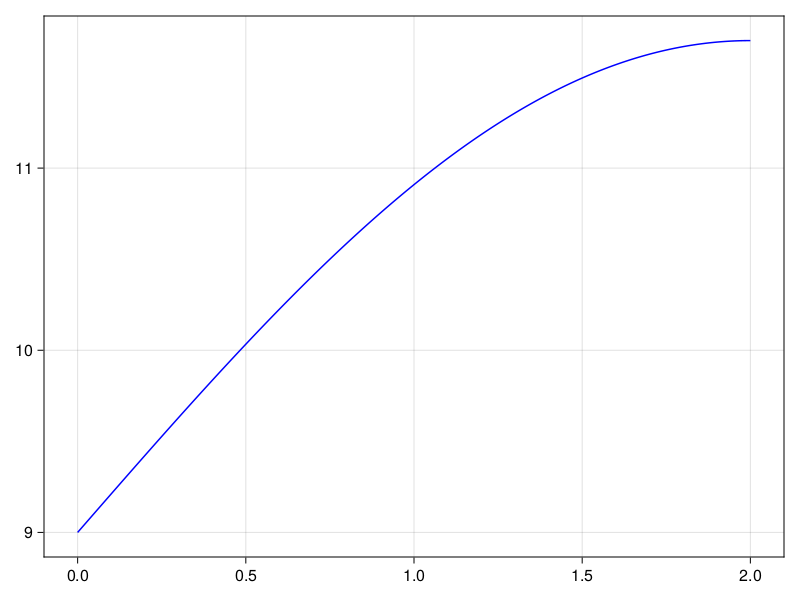

In [79]:
function dirichlet_delta_pull(t)
    if t <= time_pull
        return max_pull_perc*init_L*sin(pi/2*t/time_pull)
    else
        return max_pull_perc*init_L
    end
end

function dirichlet_delta_pull_and_push(t)
    if t <= 2*time_pull
        return max_pull_perc*init_L*sin(pi/2*t/time_pull)
    else
        return 0
    end
end

dirichlet_delta(t) = dirichlet_delta_pull_and_push(t)

g(t) = init_L + dirichlet_delta(t)

xs = range(0, time_horizon, length=1000)
lines(xs, g.(xs), color=:blue)

Task:

Given an initial length of the rod compute the minimal configuration of the atoms.
(No dissipation is used here.)

We try several initial values:
- uniform distribution
- crack at bond i

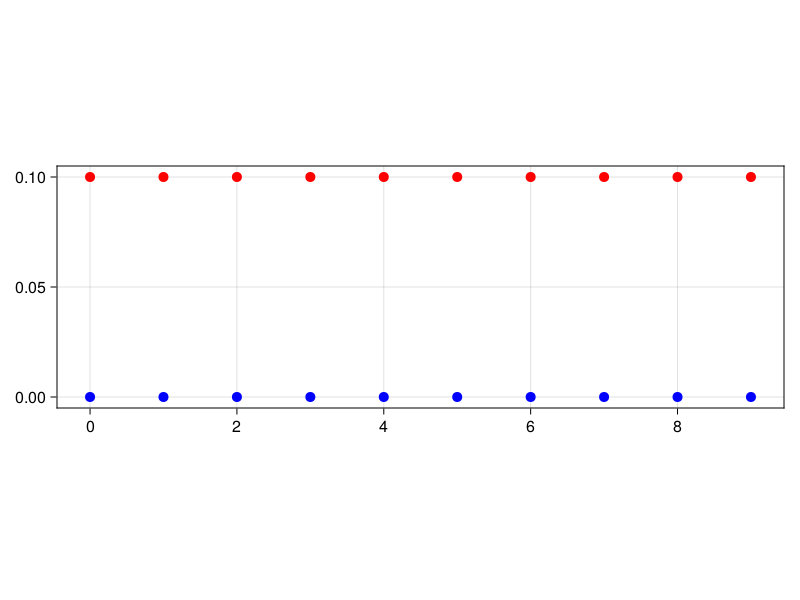

In [80]:
function plot_rod!(ax, delta_y; shift=0., color=:blue)
    y = [0.]
    for dy in delta_y
        push!(y, y[end]+dy)
    end
    
    scatter!(ax, y, shift*ones(length(y)), color=color, markersize=10)
end
fig = Figure()
ax = Axis(fig[1, 1], aspect=3)
plot_rod!(ax, pref_dist*ones(num_bonds))
plot_rod!(ax, pref_dist*ones(num_bonds), shift=0.1, color=:red)
fig

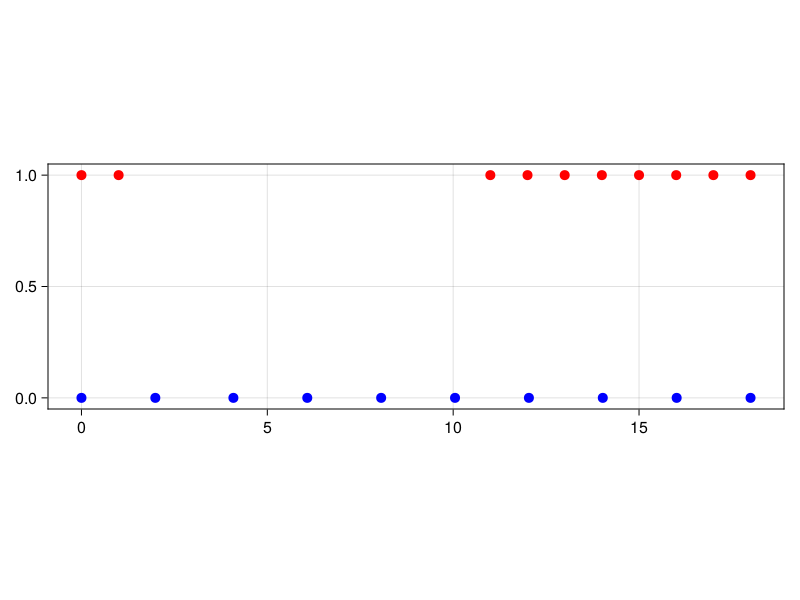

In [81]:
L = 2*num_bonds*pref_dist
broken_bond = 2
max_crack = L - (num_bonds-1)*pref_dist
sigma = pref_dist/100

function get_start_delta_y(i; favor=-1, L=2*num_bonds*pref_dist)
    uniform_dist = L / num_bonds
    
    if favor == -1
        return uniform_dist
    end
    
    diff = pref_dist/10
    if i != favor
        return uniform_dist - diff/(num_bonds-1)
    else
        return uniform_dist + diff
    end
end

function get_noisy_start_delta_y(sigma)
    uniform_dist = L / num_bonds
    start_delta_y = [uniform_dist + sigma*(2*rand()-1) for _ in 1:num_bonds]
    new_L = sum(start_delta_y)
    (L/new_L)*start_delta_y
end

# delta_y_start = [get_start_delta_y(i, favor=broken_bond, L=L) for i in 1:num_bonds]
# delta_y_start = get_noisy_start_delta_y(sigma)
delta_y_start = [get_start_delta_y(i, favor=broken_bond, L=L) for i in 1:num_bonds]

rate_independent = Model(
    ()->MadNLP.Optimizer(
        print_level=MadNLP.WARN,
        # acceptable_tol=1e-8,
        # max_iter=1000
    )
)

@variable(
    rate_independent,
    0 <= delta_y[i=1:num_bonds] <= max_crack,
    start=delta_y_start[i]
)

@constraint(
    rate_independent, lenght_L,
    sum(delta_y[i] for i in 1:num_bonds) == L
)

register(rate_independent, :W, 1, lennard_jones, autodiff = true)
@NLobjective(
    rate_independent, Min, 
    sum(W(delta_y[i]^2) for i in 1:num_bonds)
)

optimize!(rate_independent)

empty!(ax)
plot_rod!(ax, delta_y_start)
plot_rod!(ax, value.(delta_y), shift=1, color=:red)
fig

Try a global minimization without starting value.
(Of course this is much harder to optimize.)

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


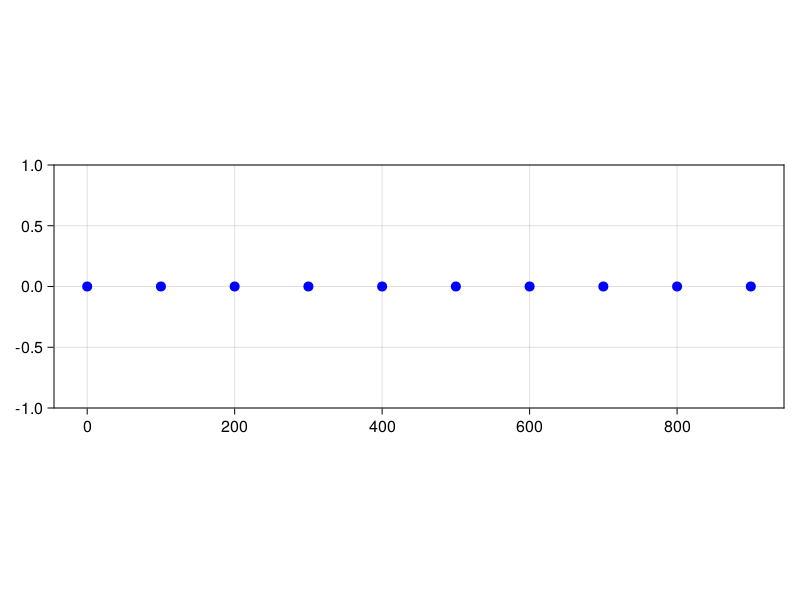

In [82]:
L = 100*num_bonds*pref_dist
max_crack = L - (num_bonds-1)*pref_dist

rate_independent = Model(
    ()->MadNLP.Optimizer(
        print_level=MadNLP.WARN,
        # acceptable_tol=1e-8,
        # max_iter=1000
    )
)

# no start value
@variable(rate_independent, 0 <= delta_y[i=1:num_bonds] <= max_crack)

@constraint(
    rate_independent, lenght_L,
    sum(delta_y[i] for i in 1:num_bonds) == L
)

register(rate_independent, :W, 1, lennard_jones, autodiff = true)
@NLobjective(
    rate_independent, Min, 
    sum(W(delta_y[i]^2) for i in 1:num_bonds)
)

optimize!(rate_independent) # Does not find the correct global minimum!

empty!(ax)
plot_rod!(ax, value.(delta_y))
println(value.(delta_y))
fig

In [84]:
step = 2

minmove = Model(
    ()->MadNLP.Optimizer(
        print_level=MadNLP.WARN,
        # acceptable_tol=1e-8,
        # max_iter=1000
    )
)

L = g((step-1)/fps)

# uniform distribution of atoms at the start of the simulation
@NLparameter(
    minmove, 
    prev_delta_y[i=1:num_bonds] == init_L / num_bonds
)
@NLexpression(
    minmove, prev_y[i=1:num_atoms],
    sum(prev_delta_y[j] for j in 1:i-1),
)

@NLparameter(minmove, max_elong_sq[i=1:num_bonds] == value(prev_delta_y[i])^2)
@NLparameter(minmove, broken[i=1:num_bonds] == 0.)

delta_L = L - init_L
# initial guess: uniform expansion of all bonds
@variable(
    minmove, 0 <= delta_y[i=1:num_bonds] <= max_crack,
    start=value(prev_delta_y[i]) + delta_L/num_bonds
)
@expression(minmove, y[i=1:num_atoms], sum(delta_y[j] for j in 1:i-1))

# Dirichlet boundary condition
@constraint(minmove, dirichlet_right, y[end] == L)

# Energy
@expression(minmove, dist_sq[i=1:num_bonds], delta_y[i]^2)
@NLexpression(
    minmove, damaged_dist_sq[i=1:num_bonds],
    (
        dist_sq[i]*exp(soft_max_alpha*dist_sq[i]) +
        max_elong_sq[i]*exp(soft_max_alpha*max_elong_sq[i])
    ) / (exp(soft_max_alpha*dist_sq[i]) + exp(soft_max_alpha*max_elong_sq[i]))
)
register(minmove, :W, 1, lennard_jones, autodiff = true)
@NLexpression(
    minmove, energy,
    sum((1-broken[i])*W(dist_sq[i]) + broken[i]*(
        (
            W(dist_sq[i])*exp(soft_max_alpha*W(dist_sq[i])) +
            W(max_elong_sq[i])*exp(soft_max_alpha*W(max_elong_sq[i]))
        ) / (exp(soft_max_alpha*W(dist_sq[i])) + exp(soft_max_alpha*W(max_elong_sq[i])))
    ) for i in 1:num_bonds)
)

# Dissipation
@NLexpression(
    minmove, dissipation,
    .5*sum((y[i] - prev_y[i])^2 for i in 2:num_atoms-1)
)

@NLobjective(minmove, Min, energy + diss_coeff*fps*dissipation)

optimize!(minmove)

value.(y)

10-element Vector{Float64}:
 0.0
 1.0002308645499407
 2.0005584886618113
 3.0011210029653226
 4.00215852436586
 5.004124306342627
 6.007916088596202
 7.0154253209291415
 8.031173107174533
 9.07067776043126